In [2]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

import numpy as np
import pandas as pd

# Matrix dictionary/list

n=9
A=np.random.randn(n,n)


def generate_pivot_graph(A,plot=True,verbose=False):
    growth_factor_list=[]
    if verbose:
        for m in tqdm(itertools.permutations(A),total=math.factorial(n)):
            growth_factor_list.append(get_gf(np.array(m)))
    else:
        for m in itertools.permutations(A):
            growth_factor_list.append(get_gf(np.array(m)))
    
    P,L,U,gf1=GEPP(A,compute_P=True)
    # PA=L1U1

    gf2=get_gf(np.matmul(P,A))
    growth_factor_list.append(gf2)
    # PA=L2U2

    # # divide by minimum
    # min_gf=min(growth_factor_list)
    # growth_factor_list=[i/min_gf for i in growth_factor_list]

    if verbose:

        print("Minimum Growth Factor: ",min(growth_factor_list))
        print("GEPP Growth Factor: ",growth_factor_list[-1])
        print("Maximum Growth Factor: ",max(growth_factor_list))

    if plot:
        plt.hist(growth_factor_list,bins=250)

        # Label last element
        plt.text(growth_factor_list[-1], 0, str(round(growth_factor_list[-1],3)), fontsize=12)

    return growth_factor_list

def GE(A):
    n = len(A)
    A = np.array(A)

    growth_factors=[]

    L = np.zeros((n, n))
    U = np.zeros((n, n))

    for i in range(n):
        L[i, i] = 1
        for j in range(i + 1):
            U[j, i] = A[j, i] - np.dot(L[j, :j], U[:j, i])
        for j in range(i + 1, n):
            L[j, i] = (A[j, i] - np.dot(L[j, :i], U[:i, i])) / U[i, i]

        iteration_growth_factor = np.max(np.abs(U)) / np.max(np.abs(A))

        growth_factors.append(iteration_growth_factor)

    return L, U, growth_factors

def GEPP(A,compute_P=False):
    n = len(A)
    A = np.array(A)

    growth_factors=[]

    L = np.zeros((n, n))
    U = np.zeros((n, n))
    P=np.eye(n)

    # Also compute P
    for i in range(n):
        max_index = np.argmax(np.abs(A[i:, i])) + i

        A[[i, max_index]] = A[[max_index, i]]

        P[[i, max_index]] = P[[max_index, i]]

        L[i, i] = 1
        for j in range(i + 1):
            U[j, i] = A[j, i] - np.dot(L[j, :j], U[:j, i])
        for j in range(i + 1, n):
            L[j, i] = (A[j, i] - np.dot(L[j, :i], U[:i, i])) / U[i, i]


        iteration_growth_factor = np.max(np.abs(U)) / np.max(np.abs(A))

        growth_factors.append(iteration_growth_factor)


    if compute_P:
        return P,L, U, growth_factors
    else:
        return L, U, growth_factors

def get_gf(A,method="GE"):
    if method=="GE":
        L,U,gf=GE(A)
    elif method=="GEPP":
        L,U,gf=GEPP(A)
    else:
        raise ValueError("Method not recognized")
    
    return np.max(gf)

def plot_gf(A,method="GE"):
    if method=="GE":
        L,U,gf=GE(A)
    elif method=="GEPP":
        L,U,gf=GEPP(A)
    else:
        raise ValueError("Method not recognized")
    plt.figure(figsize=(10,10))
    plt.plot(gf)
    plt.show()

def compare_gf(A):
    L,U,gf=GE(A)
    L,U,gfpp=GEPP(A)
    plt.figure(figsize=(10,10))
    plt.title("Growth Factor Comparison")
    plt.ylabel("Growth Factor")
    plt.xlabel("Iteration")
    plt.plot(gf,label="GE")
    plt.plot(gfpp,label="GEPP")
    plt.legend()
    plt.show()

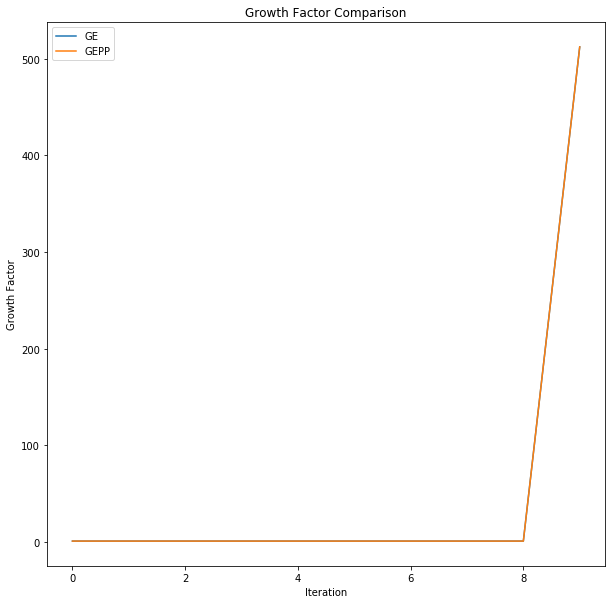

GE Growth Factor:  512.0
GEPP Growth Factor:  512.0


In [27]:

def wilkinsonMatrix(n):
    A = np.zeros((n, n))
    for i in range(n):
        A[i, i] = 1
        if i < n - 1:
            A[i + 1:, i] = -1
        
    # lasr colummn is all 1
    A[:, -1] = 1
        

    return A

def GEUnstableMatrix():
    A=np.array([
    [1e-10, 1],
    [1, 1]])

    return A

n=10

A=wilkinsonMatrix(n)

compare_gf(A)
print("GE Growth Factor: ",get_gf(A))
print("GEPP Growth Factor: ",get_gf(A,method="GEPP"))

In [15]:
# Function
n=10
iters=100000
df=pd.DataFrame(columns=["method","gf_end","gf_max"])

methods=["GE","GEPP","GE_Pivoted"]

A_list=[np.random.randn(n,n) for i in range(iters)]

for method in methods:
    # average over 100 runs
    gf_end=[]
    gf_max=[]
    for i in tqdm(range(iters)):
        A=A_list[i]
        
        
        if method=="GE":
            L,U,gf=GE(A)
        elif method=="GEPP":
            L,U,gf=GEPP(A)
        elif method=="GE_Pivoted":
            P,L,U,gf=GEPP(A,compute_P=True)
            L,U,gf=GE(P@A)
        else:
            raise ValueError("Method not recognized")
        
        gf_end.append(gf[-1])
        gf_max.append(np.max(gf))
    df=df.append({"method":method,"gf_end":np.mean(gf_end),"gf_max":np.mean(gf_max)},ignore_index=True)

df

100%|██████████| 100000/100000 [01:42<00:00, 978.80it/s]


,method,gf_end,gf_max
0,GE,85.169090,85.169090
1,GEPP,53.552883,53.552883
2,GE_Pivoted,33.643115,33.643115


In [21]:
def iteratedGEPP(A):
    n=len(A)
    P1,L1,U1,gf1=GEPP(A,compute_P=True)

    gf1=get_gf(A,method="GEPP")
    gf2=get_gf(P1@A,method="GE")
    gf3=get_gf(P1@A,method="GEPP")

    return (gf1,gf2,gf3)
    

n=5

results=[]
for i in tqdm(range(10)):
    A=np.random.randn(n,n)
    results.append(iteratedGEPP(A))

results=np.array(results)

# averages
print("GEPP: ",np.mean(results[:,0]))
print("GE: ",np.mean(results[:,1]))
print("GEPP: ",np.mean(results[:,2]))

100%|██████████| 10/10 [00:00<00:00, 447.85it/s]

GEPP:  2.2551942465844563
GE:  2.315913969834575
GEPP:  2.315913969834575


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [01:52<00:00, 11.22s/it]


GEPP average:  8.498884096468988


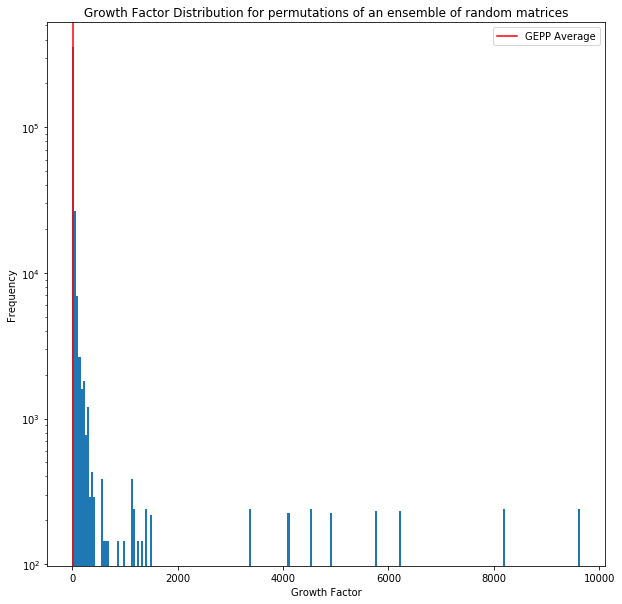

In [16]:
n=8
iters=10
results=[]
results_gepp=[]

for i in tqdm(range(iters)):
    A=np.random.randn(n,n)
    result=generate_pivot_graph(A,plot=False)

    results.append(result)
    results_gepp.append(get_gf(A,method="GEPP"))

results=np.array(results)
results_gepp=np.array(results_gepp)
gepp_avg=np.mean(results_gepp)

# Plot
plt.figure(figsize=(10,10))
plt.title("Growth Factor Distribution for permutations of an ensemble of random matrices")
plt.ylabel("Frequency")
plt.xlabel("Growth Factor")
plt.yscale("log")
plt.hist(results.flatten(),bins=250)
# pplot gepp average
plt.axvline(x=gepp_avg,color="red",label="GEPP Average")
plt.legend()


print("GEPP average: ",gepp_avg)
# Is partial pivoting on an average as good as a random permutation? Ie. is P_pp=P_rand?